In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [3]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [6]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [7]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [8]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [9]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+------------------------+---------------------------------------------------+
| pair id |  nid  |     ES transcript      |                   EN translation                  |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19997 | CINCO OCHO CUATRO SEIS |                FIVE EIGHT FOUR SIX                |
+---------+-------+------------------------+---------------------------------------------------+
|  16210  | 19998 | CINCO OCHO CUATRO SEIS | EH SEE FOUR THE ONLY THING WANT KNOW IS THAT THAT |
|         |       |                        |   THE PHONE IS RIGHT FOUR EIGHT THREE FIVE EIGHT  |
|         |       |                        |  FOUR SIX IS THE MOST IMPORTANT THING BECAUSE THE |
|         |       |                        |                  WASHINGTON CODE                  |
+---------+-------+------------------------+---------------------------------------------------+


## Pseudotext analysis

In [10]:
train_segment_list_fname, dev_segment_list_fname

(u'../train-files-85-120.txt', u'../train-files-81-84.txt')

In [11]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [12]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [13]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [14]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

839
1031
1630


In [15]:
def mini_print(out_cols, out_rows):
    out_line = PrettyTable(out_cols)
    out_line.add_row(out_rows)
    print(" & ".join(out_cols))
    print(" & ".join(map(str, out_rows)))
    print(out_line)

In [16]:
def oov_summary(dev_sids, feats_dict):
    dev_words = []
    train_words = []
    oov_pwords = []
    for did in dev_sids:
        dev_words.extend([w.decode('utf-8') for w in feats_dict[did]])
    for tid in train_sids:
        train_words.extend([w.decode('utf-8') for w in feats_dict[tid]])
    set_train_words = set(train_words)
    oov_words = [cid for cid in dev_words if cid not in set_train_words and cid != "-1"]
    missing_train_words = [cid for cid in train_words if cid == "-1"]
    missing_words = [cid for cid in dev_words if cid == "-1"]
    out_cols = ["train words", "dev words", "oov", "oov types", "miss.", "oov + miss.", "vocab", "oov vocab"]
    out_rows = [len(train_words), len(dev_words), len(oov_words), len(set(oov_words)), \
                len(missing_words), len(oov_words) + len(missing_words), len(set(dev_words)), len(set(oov_words))]
    mini_print(out_cols, out_rows)
    return Counter(train_words), Counter(dev_words), Counter(oov_words)

In [17]:
train_pwords, dev_pwords, oov_pwords = oov_summary(dev_sids, feats_dict)
train_gold_words, dev_gold_words, oov_gold_words = oov_summary(dev_sids, gold_feats_dict)

train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
15168 & 2054 & 1031 & 839 & 424 & 1455 & 1345 & 839
+-------------+-----------+------+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov  | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+------+-----------+-------+-------------+-------+-----------+
|    15168    |    2054   | 1031 |    839    |  424  |     1455    |  1345 |    839    |
+-------------+-----------+------+-----------+-------+-------------+-------+-----------+
train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
26812 & 3647 & 570 & 424 & 0 & 570 & 1220 & 424
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
|    26812    |    3647

In [18]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 506
translations missing for: 1


In [19]:
def recall_summary(eval_dict, dev_sids, feats_dict, oov_words, k):
    k = 10
    num_en_oov = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_inv_and_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) > 0])
    num_only_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_en = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
    num_en_missing = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if feats_dict[sid] == ['-1']])

    num_en_pred = sum([eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
    num_en_corr_pred = sum([eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

    out_cols = ["total en", "en oov", "en missing", "upper bound recall"]
    out_rows = [num_en, num_en_oov, num_en_missing, "{0:.3f}".format((num_en-num_en_oov-num_en_missing)/num_en)]

    mini_print(out_cols, out_rows)

    out_cols = ["k", "\\# corr.", "\\# pred", "prec.", "rec.", "rec. w/o miss.", "rec. w/o oov", "rec. w/o miss.+oov"]
    out_rows = map(lambda v: "{0:.2f} \%".format(v*100) if type(v) != int else v, \
                   [k, num_en_corr_pred, num_en_pred, (num_en_corr_pred/num_en_pred), (num_en_corr_pred/num_en), num_en_corr_pred/(num_en-num_en_missing), \
                    num_en_corr_pred/(num_en-num_en_oov), num_en_corr_pred/(num_en-num_en_missing-num_en_oov)])
    mini_print(out_cols, out_rows)
    mini_print(['inv+oov', 'only oov'], [num_inv_and_oov, num_only_oov])

In [20]:
k=10
recall_summary(mt_pseudo_eval_dict, dev_sids, feats_dict, oov_pwords, k)

total en & en oov & en missing & upper bound recall
3530 & 795 & 1055 & 0.476
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   3530   |  795   |    1055    |       0.476        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 74 & 3550 & 2.08 \% & 2.10 \% & 2.99 \% & 2.71 \% & 4.40 \%
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.  |   rec.  | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| 10 |    74    |   3550  | 2.08 \% | 2.10 \% |    2.99 \%     |   2.71 \%    |      4.40 \%       |
+----+----------+---------+---------+---------+----------------+--------------+---

In [21]:
recall_summary(mt_gold_eval_dict, dev_sids, gold_feats_dict, oov_gold_words, k)
'''
The impact of oov words is less in the case of gold features, 
as other words in the utterances still make predictions. 

However, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when
oov words are encountered
'''

total en & en oov & en missing & upper bound recall
3530 & 23 & 0 & 0.993
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   3530   |   23   |     0      |       0.993        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 1906 & 10198 & 18.69 \% & 53.99 \% & 53.99 \% & 54.35 \% & 54.35 \%
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.   |   rec.   | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| 10 |   1906   |  10198  | 18.69 \% | 53.99 \% |    53.99 \%    |   54.35 \%   |      54.35 \%      |
+----+----------+---------+----------+----------+----------------+----

'\nThe impact of oov words is less in the case of gold features, \nas other words in the utterances still make predictions. \n\nHowever, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when\noov words are encountered\n'

In [22]:
mini_print(["train fids", "dev fids", "train sids", "dev sids"], \
          [len(train_fids), len(dev_fids), len(train_sids), len(dev_sids)])

train fids & dev fids & train sids & dev sids
32 & 4 & 5751 & 818
+------------+----------+------------+----------+
| train fids | dev fids | train sids | dev sids |
+------------+----------+------------+----------+
|     32     |    4     |    5751    |   818    |
+------------+----------+------------+----------+


In [23]:
def get_dur_for_sids(sids, align_dict):
    dur = 0
    for sid in sids:
        dur += sum([word.end-word.start for word in align_dict[sid.split('.')[0]][sid]['es']])
    return dur / (100 * 3600)

In [24]:
# train sids duration
train_sid_dur = "%.3f" % get_dur_for_sids(train_sids, align_dict)
dev_sid_dur = "%.3f" % get_dur_for_sids(dev_sids, align_dict)
mini_print(["train sid dur", "dev sid dur"], [train_sid_dur, dev_sid_dur])

train sid dur & dev sid dur
4.360 & 0.509
+---------------+-------------+
| train sid dur | dev sid dur |
+---------------+-------------+
|     4.360     |    0.509    |
+---------------+-------------+


### pseudowords

## Cluster Analysis

In [37]:
def plot_word_freq(count_dict, num=10, fig_name = '', prefix='', color='salmon'):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items()}
    pd_es_df = pd.DataFrame(sorted(count_dict.items(), reverse=True, key=lambda t:t[1])[:num], index=range(num))
    pd_es_df.columns = ["word", "freq"]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(y='word', x="freq", data=pd_es_df, label=fig_name, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))

    plt.xlabel("word counts", size=20)
    plt.ylabel("word types", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=0, size=18)

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    

In [26]:
def get_en_words(align_dict, seg_id, en_key):
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    if not en_words:
        en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    return en_words

In [27]:
def get_word_counts(w_key, feats_dict, align_dict, sids):
    if w_key.startswith('es'):
        wrds = [a.decode("utf-8") for sid in feats_dict for a in feats_dict[sid] if sid in sids]
    else:
        wrds = [a for sid in sids for a in get_en_words(align_dict, sid, w_key)]
    return Counter(wrds)

In [28]:
gold_feats_dict['001.001']

['MECHITA', 'MANDADO', 'QUI\xc3\xa9N', 'POCHO']

In [29]:
# w_count['train']['es'] = get_word_counts('')
# w_count['es'] = Counter([a.word.decode("utf-8") for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es']])
# w_count['es_cnt'] = Counter([a.word.decode("utf-8") for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['es_cnt']])
# w_count['en'] = Counter([a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en']])
# w_count['en_cnt'] = Counter([a.word for fid in align_dict for sid in align_dict[fid] for a in align_dict[fid][sid]['en_cnt']])

# w_count['pwords_train'] = Counter(train_pwords)
# w_count['pwords_dev'] = Counter(dev_pwords)
# w_count['pwords_oov'] = Counter(oov_pwords)

In [30]:
w_count = {'train': {}, 'dev': {}}
count_tups = [('train', 'es_cnt', train_sids), ('train', 'en_cnt', train_sids), \
              ('dev', 'es_cnt', dev_sids), ('dev', 'en_cnt', dev_sids)]
for t,k,s in count_tups:
    w_count[t][k] = get_word_counts(k, gold_feats_dict, align_dict, s)


In [32]:
temp_train_pwords = {k:v for k, v in train_pwords.items()}
del temp_train_pwords['-1']
temp_train_pwords.items()[:5], w_count['train']['es_cnt'].items()[:5]

([(u'11542', 2), (u'11543', 2), (u'11540', 2), (u'11541', 2), (u'11546', 2)],
 [(u'FONDO', 1),
  (u'GAVETERO', 1),
  (u'REGLA', 1),
  (u'FRONTERA', 3),
  (u'DOBLE', 5)])

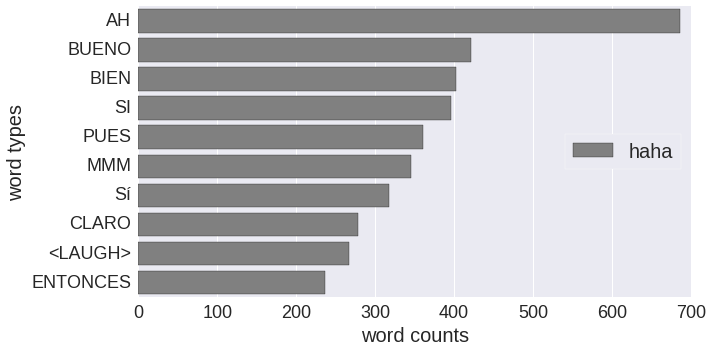

In [40]:
plot_word_freq(train_gold_words, fig_name="haha", color='grey')

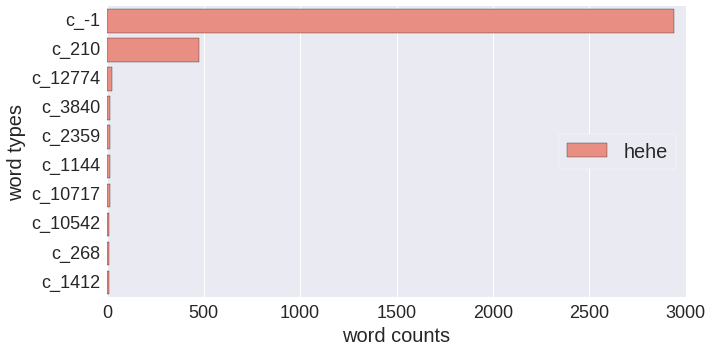

In [44]:
plot_word_freq(train_pwords, fig_name="hehe", prefix='c', color="salmon")

In [ ]:
# plot_word_freq(train_pwords)
plot_word_freq(w_count['train']['es_cnt'])

In [ ]:
len(oov_pwords)

In [ ]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
# clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [ ]:
clusters[0], nodes_dict[1], nodes_dict[2]

In [ ]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(5)

In [ ]:
clusters_df['cross_file'] = clusters_df.apply(lambda row: len(set(row['sids'])) > 1, axis=1)

In [ ]:
clusters_df['fid_min'] = clusters_df.apply(lambda row: min(row['sids']), axis=1)

In [ ]:
clusters_df['fid_max'] = clusters_df.apply(lambda row: max(row['sids']), axis=1)

In [ ]:
clusters_df['oov'] = clusters_df.apply(lambda row: max(row['sids']) not in train_fids and \
                                                    min(row['sids']) in dev_fids, axis=1)

In [ ]:
len([cid for cid in clusters_stats['sids'] if len(set(cid)) > 1])

In [ ]:
clusters_df.head(2)

In [ ]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

In [ ]:
len(clusters_df[clusters_df.is_dev])

In [ ]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

In [ ]:
# !ls ../../../ZRTools/exp/callhome/tmpwav/

In [ ]:
Audio('../../../ZRTools/exp/callhome/tmpwav/0058.wav')

In [ ]:
k = 1
uttr = "010.169"
# uttr = "011.178"
# uttr = "002.008"

In [ ]:
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['es']]))
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['en_cnt']]))

In [ ]:
print(" ".join([w.decode("utf-8") for w in gold_feats_dict[uttr]])),
print(" ".join([w.decode("utf-8") for w in feats_dict[uttr]]))

In [ ]:
# pseudo_probs_dict['1354']

In [ ]:
print(" ".join([w.decode("utf-8") for w in mt_gold_pred_dict[k][uttr]])),
print(" ".join([w.decode("utf-8") for w in mt_pseudo_pred_dict[k][uttr]]))

In [ ]:
[(key, v['t']) for key,v in mt_pseudo_eval_dict['dev'][k].items() if type(v) == dict and v['cp'] == 1]

## Calculate duration in dev, test, and training sets

In [ ]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [ ]:
dur = {"tot":{}, "ge500ms":{}}

In [ ]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [ ]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

In [ ]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [ ]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

In [ ]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

In [ ]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, t_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(t_files, len(test_dur_500ms_list))

In [ ]:
# Train subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 85, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 85, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

# Dev subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 81, 84)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 81, 84)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))